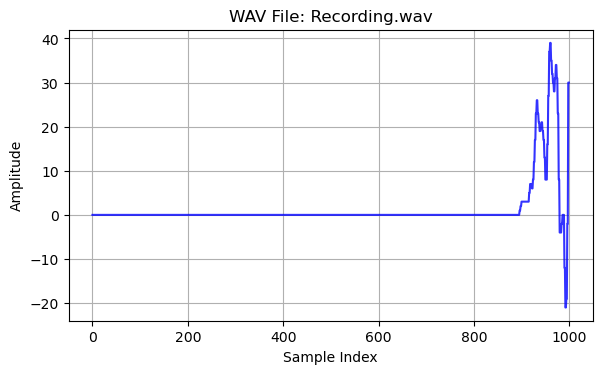

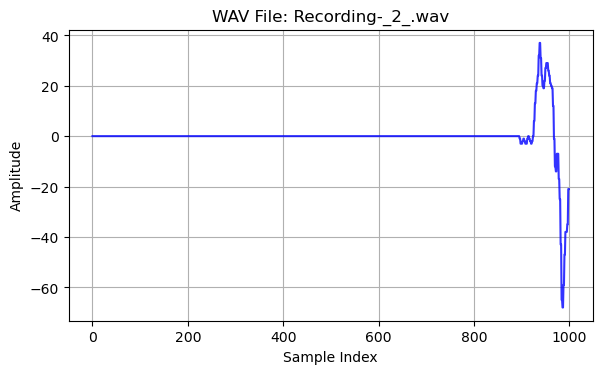

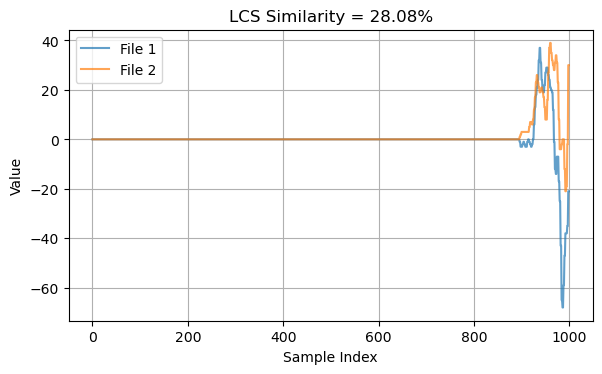

In [13]:
"""
Project Title: Pattern Similarity Detection Using LCS on Audio and Image Data
Author: Sarthak Siddharth Shrungarpawar
Description:
    This project demonstrates how the Longest Common Subsequence (LCS) algorithm
    can be applied to numeric data derived from audio (.wav) and image (.jpeg)
    files to measure similarity — with GUI integration using Tkinter and
    embedded waveform visualization.
"""

import wave
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import os
import tkinter as tk
from tkinter import filedialog, messagebox, ttk


# ---------------------------------------------------------------
# STEP 1: Convert .wav file to text
# ---------------------------------------------------------------
def wav_to_txt(filepath, out_txt, canvas_area):
    try:
        with wave.open(filepath, 'rb') as wav_file:
            n_frames = wav_file.getnframes()
            frames = wav_file.readframes(n_frames)
            samples = np.frombuffer(frames, dtype=np.int16)

        np.savetxt(out_txt, samples, fmt='%d')
        messagebox.showinfo("Success", f"[AUDIO] Saved {len(samples)} samples → {out_txt}")

        # Display waveform in GUI
        plot_waveform(samples, title=f"WAV File: {os.path.basename(filepath)}", canvas_area=canvas_area)

    except Exception as e:
        messagebox.showerror("Error", f"Error converting WAV: {e}")


# ---------------------------------------------------------------
# STEP 2: Convert .jpeg file to text
# ---------------------------------------------------------------
def jpeg_to_txt(filepath, out_txt, canvas_area):
    try:
        img = Image.open(filepath).convert('L')  # grayscale
        arr = np.array(img).flatten()
        np.savetxt(out_txt, arr, fmt='%d')
        messagebox.showinfo("Success", f"[IMAGE] Saved {arr.size} pixel values → {out_txt}")

        # Display grayscale intensity plot
        plot_waveform(arr[:1000], title=f"JPEG Intensity Preview: {os.path.basename(filepath)}", canvas_area=canvas_area)

    except Exception as e:
        messagebox.showerror("Error", f"Error converting JPEG: {e}")


# ---------------------------------------------------------------
# STEP 3: Read sequence data from text file
# ---------------------------------------------------------------
def read_sequence(filepath, limit=None):
    try:
        with open(filepath, 'r') as f:
            seq = [int(x.strip()) for x in f.readlines()]
        if limit:
            seq = seq[:limit]
        return seq
    except Exception as e:
        messagebox.showerror("Error", f"Error reading {filepath}: {e}")
        return []


# ---------------------------------------------------------------
# STEP 4: LCS Algorithm (Space-optimized)
# ---------------------------------------------------------------
def lcs_length(seq1, seq2):
    if len(seq1) < len(seq2):
        seq1, seq2 = seq2, seq1

    prev = [0] * (len(seq2) + 1)
    curr = [0] * (len(seq2) + 1)

    for i in range(1, len(seq1) + 1):
        for j in range(1, len(seq2) + 1):
            if seq1[i - 1] == seq2[j - 1]:
                curr[j] = prev[j - 1] + 1
            else:
                curr[j] = max(prev[j], curr[j - 1])
        prev, curr = curr, [0] * (len(seq2) + 1)

    return prev[-1]


# ---------------------------------------------------------------
# STEP 5: Compare Two Files using LCS
# ---------------------------------------------------------------
def compare_sequences(file1, file2, canvas_area, sample_limit=5000):
    seq1 = read_sequence(file1, limit=sample_limit)
    seq2 = read_sequence(file2, limit=sample_limit)

    if not seq1 or not seq2:
        return

    lcs_len = lcs_length(seq1, seq2)
    similarity = lcs_len / min(len(seq1), len(seq2)) * 100

    messagebox.showinfo(
        "LCS Similarity Result",
        f"LCS Length: {lcs_len}\n"
        f"Seq1 Length: {len(seq1)}\n"
        f"Seq2 Length: {len(seq2)}\n"
        f"Similarity: {similarity:.2f}%"
    )

    # Show both sequences in embedded graph
    plot_comparison(seq1, seq2, similarity, canvas_area)


# ---------------------------------------------------------------
# STEP 6: Plot Waveform in GUI (Matplotlib Embedded)
# ---------------------------------------------------------------
def plot_waveform(data, title, canvas_area):
    for widget in canvas_area.winfo_children():
        widget.destroy()

    fig, ax = plt.subplots(figsize=(6, 2.5), dpi=100)
    ax.plot(data[:1000], color='blue', alpha=0.8)
    ax.set_title(title)
    ax.set_xlabel("Sample Index")
    ax.set_ylabel("Amplitude")
    ax.grid(True)

    canvas = FigureCanvasTkAgg(fig, master=canvas_area)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)


def plot_comparison(seq1, seq2, similarity, canvas_area):
    for widget in canvas_area.winfo_children():
        widget.destroy()

    fig, ax = plt.subplots(figsize=(6, 2.5), dpi=100)
    ax.plot(seq1[:1000], label='File 1', alpha=0.7)
    ax.plot(seq2[:1000], label='File 2', alpha=0.7)
    ax.set_title(f"LCS Similarity = {similarity:.2f}%")
    ax.set_xlabel("Sample Index")
    ax.set_ylabel("Value")
    ax.legend()
    ax.grid(True)

    canvas = FigureCanvasTkAgg(fig, master=canvas_area)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)


# ---------------------------------------------------------------
# STEP 7: GUI Integration
# ---------------------------------------------------------------
def main_gui():
    root = tk.Tk()
    root.title("Pattern Similarity Detection Using LCS")
    root.geometry("720x580")
    root.resizable(False, False)
    root.configure(bg="#F4F6F7")

    # --- Title ---
    title_label = tk.Label(
        root, text="Pattern Similarity Detection Using LCS",
        font=("Helvetica", 15, "bold"), bg="#F4F6F7", fg="#2C3E50"
    )
    title_label.pack(pady=10)

    # --- Buttons Frame ---
    button_frame = tk.Frame(root, bg="#F4F6F7")
    button_frame.pack(pady=10)

    ttk.Style().configure("TButton", padding=8, font=("Helvetica", 11))

    # Placeholder frame for waveform plot
    canvas_frame = tk.LabelFrame(root, text="Visualization", bg="#F4F6F7", font=("Helvetica", 10, "bold"), padx=10, pady=5)
    canvas_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)

    ttk.Button(button_frame, text="🎵 Convert WAV → TXT", command=lambda: select_wav(canvas_frame)).grid(row=0, column=0, padx=10, pady=5)
    ttk.Button(button_frame, text="🖼️ Convert JPEG → TXT", command=lambda: select_jpeg(canvas_frame)).grid(row=0, column=1, padx=10, pady=5)
    ttk.Button(button_frame, text="🔍 Compare Two TXT Files", command=lambda: compare_txt(canvas_frame)).grid(row=0, column=2, padx=10, pady=5)
    ttk.Button(button_frame, text="❌ Exit", command=root.quit).grid(row=0, column=3, padx=10, pady=5)

    footer = tk.Label(
        root, text="Developed by Sarthak Siddharth Shrungarpawar",
        bg="#F4F6F7", fg="#7B7D7D", font=("Arial", 9)
    )
    footer.pack(side="bottom", pady=5)

    root.mainloop()


# ---------------------------------------------------------------
# STEP 8: File selection helpers
# ---------------------------------------------------------------
def select_wav(canvas_area):
    filepath = filedialog.askopenfilename(filetypes=[("WAV Files", "*.wav")])
    if filepath:
        out = os.path.splitext(filepath)[0] + "_audio.txt"
        wav_to_txt(filepath, out, canvas_area)


def select_jpeg(canvas_area):
    filepath = filedialog.askopenfilename(filetypes=[("JPEG Files", "*.jpeg *.jpg")])
    if filepath:
        out = os.path.splitext(filepath)[0] + "_image.txt"
        jpeg_to_txt(filepath, out, canvas_area)


def compare_txt(canvas_area):
    file1 = filedialog.askopenfilename(title="Select First TXT File", filetypes=[("Text Files", "*.txt")])
    file2 = filedialog.askopenfilename(title="Select Second TXT File", filetypes=[("Text Files", "*.txt")])
    if file1 and file2:
        compare_sequences(file1, file2, canvas_area)


# ---------------------------------------------------------------
# Run GUI
# ---------------------------------------------------------------
if __name__ == "__main__":
    main_gui()